# Explanation:

## Score: 0.XXXX
The target variable is: 

amount_new_house_transactions: The total monetary value of new house transactions in 10,000 yuan.

We are using some of the features found in the different csv's to predict the final amount
The method used is XGBoost with cross validation

# 1. SETUP - Dependencies, dataloading

## 1.1 Dependencies and plotting style

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import sklearn
import xgboost as xgb
import optuna

from dateutil.relativedelta import relativedelta
from xgboost.callback import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from datetime import datetime

In [2]:
# Set global plot styles
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 1.2 Loads all necessary data without any processing

We first define the datapath

In [3]:
# Define the data path
DATA_PATH = Path("/Users/nikola/Python/KaggleCompetition/data")

We load the complemetary datasets which will include many of the features

In [4]:
# Transaction Data (Monthly)
new_house = pd.read_csv(DATA_PATH / "train" / "new_house_transactions.csv")
pre_owned = pd.read_csv(DATA_PATH / "train" / "pre_owned_house_transactions.csv")
land = pd.read_csv(DATA_PATH / "train" / "land_transactions.csv")

# Nearby Sectors Transaction Data
new_house_nearby = pd.read_csv(DATA_PATH / "train" / "new_house_transactions_nearby_sectors.csv")
pre_owned_nearby = pd.read_csv(DATA_PATH / "train" / "pre_owned_house_transactions_nearby_sectors.csv")
land_nearby = pd.read_csv(DATA_PATH / "train" / "land_transactions_nearby_sectors.csv")

# Sector Features (Static)
sector_poi = pd.read_csv(DATA_PATH / "train" / "sector_POI.csv")

# Market Indicators (Time-series)
search_index = pd.read_csv(DATA_PATH / "train" / "city_search_index.csv")
city_indexes = pd.read_csv(DATA_PATH / "train" / "city_indexes.csv")

# Convert month columns to datetime for datasets that have it
datasets_with_month = [new_house, pre_owned, land, new_house_nearby, pre_owned_nearby, land_nearby, search_index]

for df in datasets_with_month:
    if 'month' in df.columns:
        df['month'] = pd.to_datetime(df['month'])

# Store in dictionary for easy access
datasets = {
    'new_house': new_house,
    'pre_owned': pre_owned,
    'land': land,
    'new_house_nearby': new_house_nearby,
    'pre_owned_nearby': pre_owned_nearby,
    'land_nearby': land_nearby,
    'sector_poi': sector_poi,
    'search_index': search_index,
    'city_indexes': city_indexes
}

/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_8344/712092853.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_8344/712092853.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_8344/712092853.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_8344/712092853

In [5]:
new_house.tail()

,month,sector,num_new_house_transactions,area_new_house_transactions,price_new_house_transactions,amount_new_house_transactions,area_per_unit_new_house_transactions,total_price_per_unit_new_house_transactions,num_new_house_available_for_sale,area_new_house_available_for_sale,period_new_house_sell_through
5428,2024-07-01,sector 91,70,7921,40967,32450.06,113,463.57,2133.0,341192.0,51.82
5429,2024-07-01,sector 92,211,22084,13949,30804.74,105,145.99,5908.0,636696.0,34.76
5430,2024-07-01,sector 93,62,8136,27452,22335.30,131,360.25,1323.0,150862.0,27.74
5431,2024-07-01,sector 94,44,5078,26367,13389.41,115,304.30,2027.0,215821.0,38.62
5432,2024-07-01,sector 96,1,140,40079,561.19,140,561.19,1.0,195.0,1.39


# 3. DATA & FEATURE ENGINEERING - Merging, cleaning, handling missing values


In [6]:
# ------------------------------------------
# 3.1 Create Master Dataset
# ------------------------------------------

# Start with new_house as base (contains target)
df = new_house.copy()

# Define target variable
target_col = 'amount_new_house_transactions'

# MINIMAL feature selection - only the most essential
columns_to_merge = {
    'pre_owned': [
        'month', 'sector',
        'amount_pre_owned_house_transactions',  # Direct substitute market
        'price_pre_owned_house_transactions'    # Price signals
    ],
    'new_house_nearby': [
        'month', 'sector',
        'amount_new_house_transactions_nearby_sectors'  # Spatial spillover
    ],
}

# Merge only essential datasets
for data, name in [(pre_owned, 'pre_owned'), 
                   (new_house_nearby, 'new_house_nearby')]:
    
    cols_to_use = [col for col in columns_to_merge[name] if col in data.columns]
    df = df.merge(data[cols_to_use], on=['month', 'sector'], how='left')
    print(f"Merged {name}: added {len(cols_to_use)-2} features, shape: {df.shape}")

print(f"\nDataset shape: {df.shape}")
print(f"Base features (excluding target): {df.shape[1] - 1}")

Merged pre_owned: added 2 features, shape: (5433, 13)
Merged new_house_nearby: added 1 features, shape: (5433, 14)

Dataset shape: (5433, 14)
Base features (excluding target): 13


In [7]:
# ------------------------------------------
# 3.2 Add Seasonal Dummy Variables
# ------------------------------------------

# Create dummy variables for peak and low months
df['is_december'] = (df['month'].dt.month == 12).astype(int)
df['is_february'] = (df['month'].dt.month == 2).astype(int)

# Verify the seasonal patterns
dec_avg = df[df['is_december'] == 1][target_col].mean()
feb_avg = df[df['is_february'] == 1][target_col].mean()
other_avg = df[(df['is_december'] == 0) & (df['is_february'] == 0)][target_col].mean()

print(f"Seasonal patterns in {target_col}:")
print(f"  December (peak): {dec_avg:,.0f}")
print(f"  February (low):  {feb_avg:,.0f}")
print(f"  Other months:    {other_avg:,.0f}")
print(f"\nAdded 2 dummy variables: is_december, is_february")
print(f"Updated dataset shape: {df.shape}")

Seasonal patterns in amount_new_house_transactions:
  December (peak): 46,470
  February (low):  19,798
  Other months:    32,619

Added 2 dummy variables: is_december, is_february
Updated dataset shape: (5433, 16)


In [8]:
# ==========================================
# 3.3 MINIMAL FEATURE ENGINEERING
# ==========================================

# Sort for lag calculations
df = df.sort_values(['sector', 'month']).reset_index(drop=True)

# 3. Essential time features
df['month_num'] = df['month'].dt.month
df['quarter'] = df['month'].dt.quarter
df['year'] = df['month'].dt.year

# 4. One key ratio
if 'price_pre_owned_house_transactions' in df.columns:
    df['new_to_preowned_price_ratio'] = (
        df['price_new_house_transactions'] / 
        df['price_pre_owned_house_transactions'].replace(0, np.nan)
    )

print(f"\nFinal feature count: {df.shape[1] - 3}")  # -3 for month, sector, target


Final feature count: 17


In [9]:
# # ------------------------------------------
# # 3.4 Handle Missing Values
# # ------------------------------------------

# # For low missing (<1%), use median
# low_missing_cols = [
#     'num_new_house_available_for_sale',
#     'area_new_house_available_for_sale',
#     'period_new_house_sell_through',
#     'price_pre_owned_house_transactions'
# ]

# for col in low_missing_cols:
#     if col in df.columns:
#         df[col].fillna(df[col].median(), inplace=True)

In [10]:
# ------------------------------------------
# 3.6 Create Lagged Features (No Data Leakage)
# ------------------------------------------

print("\n" + "="*60)
print("CREATING LAGGED FEATURES FOR TIME SERIES FORECASTING")
print("="*60)

# Sort by sector and time to ensure proper lagging
df = df.sort_values(['sector', 'month']).reset_index(drop=True)

# Keep original features (we'll need them for generating features on future data)
features_to_lag = [
    'num_new_house_available_for_sale',
    'amount_pre_owned_house_transactions',
    'period_new_house_sell_through'
]

# Create 1-month lags
for feature in features_to_lag:
    if feature in df.columns:
        lag_col_name = f'{feature}_lag1'
        df[lag_col_name] = df.groupby('sector')[feature].shift(1)
        non_null = df[lag_col_name].notna().sum()
        print(f"{lag_col_name}: {non_null}/{len(df)} non-null values")

# Create sector-level historical averages (no leakage)
print(f"\nCreating sector historical features...")
df['sector_historical_mean'] = df.groupby('sector')[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)
df['sector_historical_std'] = df.groupby('sector')[target_col].transform(
    lambda x: x.expanding().std().shift(1)
)

# Create month-level historical averages across all sectors (seasonal patterns)
df['month_historical_mean'] = df.groupby(df['month'].dt.month)[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)

# Sector-month combination average (sector-specific seasonal pattern)
df['sector_month_avg'] = df.groupby(['sector', df['month'].dt.month])[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)

# Time trend per sector (how much growth/decline over time)
df['months_since_start'] = df.groupby('sector').cumcount()

print(f"sector_historical_mean: {df['sector_historical_mean'].notna().sum()}/{len(df)} non-null")
print(f"sector_historical_std: {df['sector_historical_std'].notna().sum()}/{len(df)} non-null")
print(f"month_historical_mean: {df['month_historical_mean'].notna().sum()}/{len(df)} non-null")
print(f"sector_month_avg: {df['sector_month_avg'].notna().sum()}/{len(df)} non-null")

# Keep time features
print(f"\nTime features: is_december, is_february, year, months_since_start")

# DON'T drop original features - keep them for future feature generation
print(f"\nKeeping original features for future predictions")

# Summary
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE")
print("="*60)

all_features = [col for col in df.columns if col not in ['month', 'date', 'sector', target_col]]
print(f"Final feature count: {len(all_features)}")
print(f"Features: {all_features}")
print(f"\nRows with complete lag data: {df.dropna().shape[0]}/{len(df)}")


CREATING LAGGED FEATURES FOR TIME SERIES FORECASTING
num_new_house_available_for_sale_lag1: 5326/5433 non-null values
amount_pre_owned_house_transactions_lag1: 4698/5433 non-null values
period_new_house_sell_through_lag1: 5326/5433 non-null values

Creating sector historical features...
sector_historical_mean: 5338/5433 non-null
sector_historical_std: 5244/5433 non-null
month_historical_mean: 5421/5433 non-null
sector_month_avg: 4318/5433 non-null

Time features: is_december, is_february, year, months_since_start

Keeping original features for future predictions

FEATURE ENGINEERING COMPLETE
Final feature count: 25
Features: ['num_new_house_transactions', 'area_new_house_transactions', 'price_new_house_transactions', 'area_per_unit_new_house_transactions', 'total_price_per_unit_new_house_transactions', 'num_new_house_available_for_sale', 'area_new_house_available_for_sale', 'period_new_house_sell_through', 'amount_pre_owned_house_transactions', 'price_pre_owned_house_transactions', 'a

In [11]:
# ------------------------------------------
# 3.7 Remove Data Leakage Columns
# ------------------------------------------

# These might directly calculate the target
potential_leakage = [
    'area_new_house_transactions',  # amount = area * price
    'total_price_per_unit_new_house_transactions',  # directly related to amount
    'price_new_house_transactions',   # directly related to amount
    'price_pre_owned_house_transactions',   # directly related to amount
    'quarter',  # might indirectly leak seasonal patterns
    'area_new_house_available_for_sale',
    'total_price_per_unit_pre_owned_house_transactions',  # directly related to amount
    'month_num',  # might indirectly leak seasonal patterns
    'num_new_house_transactions'    
    'area_per_unit_new_house_transactions',  # ADD
    'amount_new_house_transactions_nearby_sectors',  # ADD
    'new_to_preowned_price_ratio'  # ADD
]

df.drop(columns=[col for col in potential_leakage if col in df.columns], inplace=True)

print(f"Remaining columns: {len(df.columns)}")

Remaining columns: 19


In [12]:
# ------------------------------------------
# 3.8 Final Dataset Info
# ------------------------------------------

print("\n" + "="*40)
print("PREPROCESSING COMPLETE")
print("="*40)
print(f"Final dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print(f"Target variable: {target_col}")
print(f"Number of features: {len(df.columns) - 1}")  # -1 for target

# Save processed data
output_path = Path("/Users/nikola/Python/KaggleCompetition/data")
df.to_csv(output_path / "processed_data.csv", index=False)
print(f"\nProcessed data saved to: {output_path / 'processed_data.csv'}")

# Keep a copy for modeling
df_processed = df.copy()


PREPROCESSING COMPLETE
Final dataset shape: (5433, 19)
Memory usage: 0.77 MB
Target variable: amount_new_house_transactions
Number of features: 18

Processed data saved to: /Users/nikola/Python/KaggleCompetition/data/processed_data.csv


In [13]:
def custom_competition_score(y_true, y_pred):
    """
    Custom competition scoring function.
    
    Stage 1: If more than 30% of samples have absolute percentage errors > 100%, return 0
    Stage 2: Otherwise, calculate MAPE on samples with APE <= 1, scaled by fraction of valid samples
    
    Returns: Score between 0 and 1 (higher is better)
    """
    # Calculate absolute percentage errors
    ape = np.abs((y_pred - y_true) / y_true)
    
    # Stage 1: Check if more than 30% have errors > 100% (i.e., > 1.0)
    extreme_errors = np.sum(ape > 1.0) / len(ape)
    
    if extreme_errors > 0.3:
        return 0.0
    
    # Stage 2: Calculate MAPE on samples with APE <= 1
    valid_mask = ape <= 1.0
    
    if np.sum(valid_mask) == 0:
        return 0.0
    
    # D: set of valid samples (APE <= 1)
    valid_ape = ape[valid_mask]
    
    # Average MAPE of valid samples
    mape_valid = np.mean(valid_ape)
    
    # Fraction of valid samples
    fraction_valid = np.sum(valid_mask) / len(ape)
    
    # Scaled MAPE
    scaled_mape = mape_valid / fraction_valid
    
    # Final score: 1 - scaled_mape
    score = 1 - scaled_mape
    
    return max(0, score)  # Ensure non-negative

## Visualisation

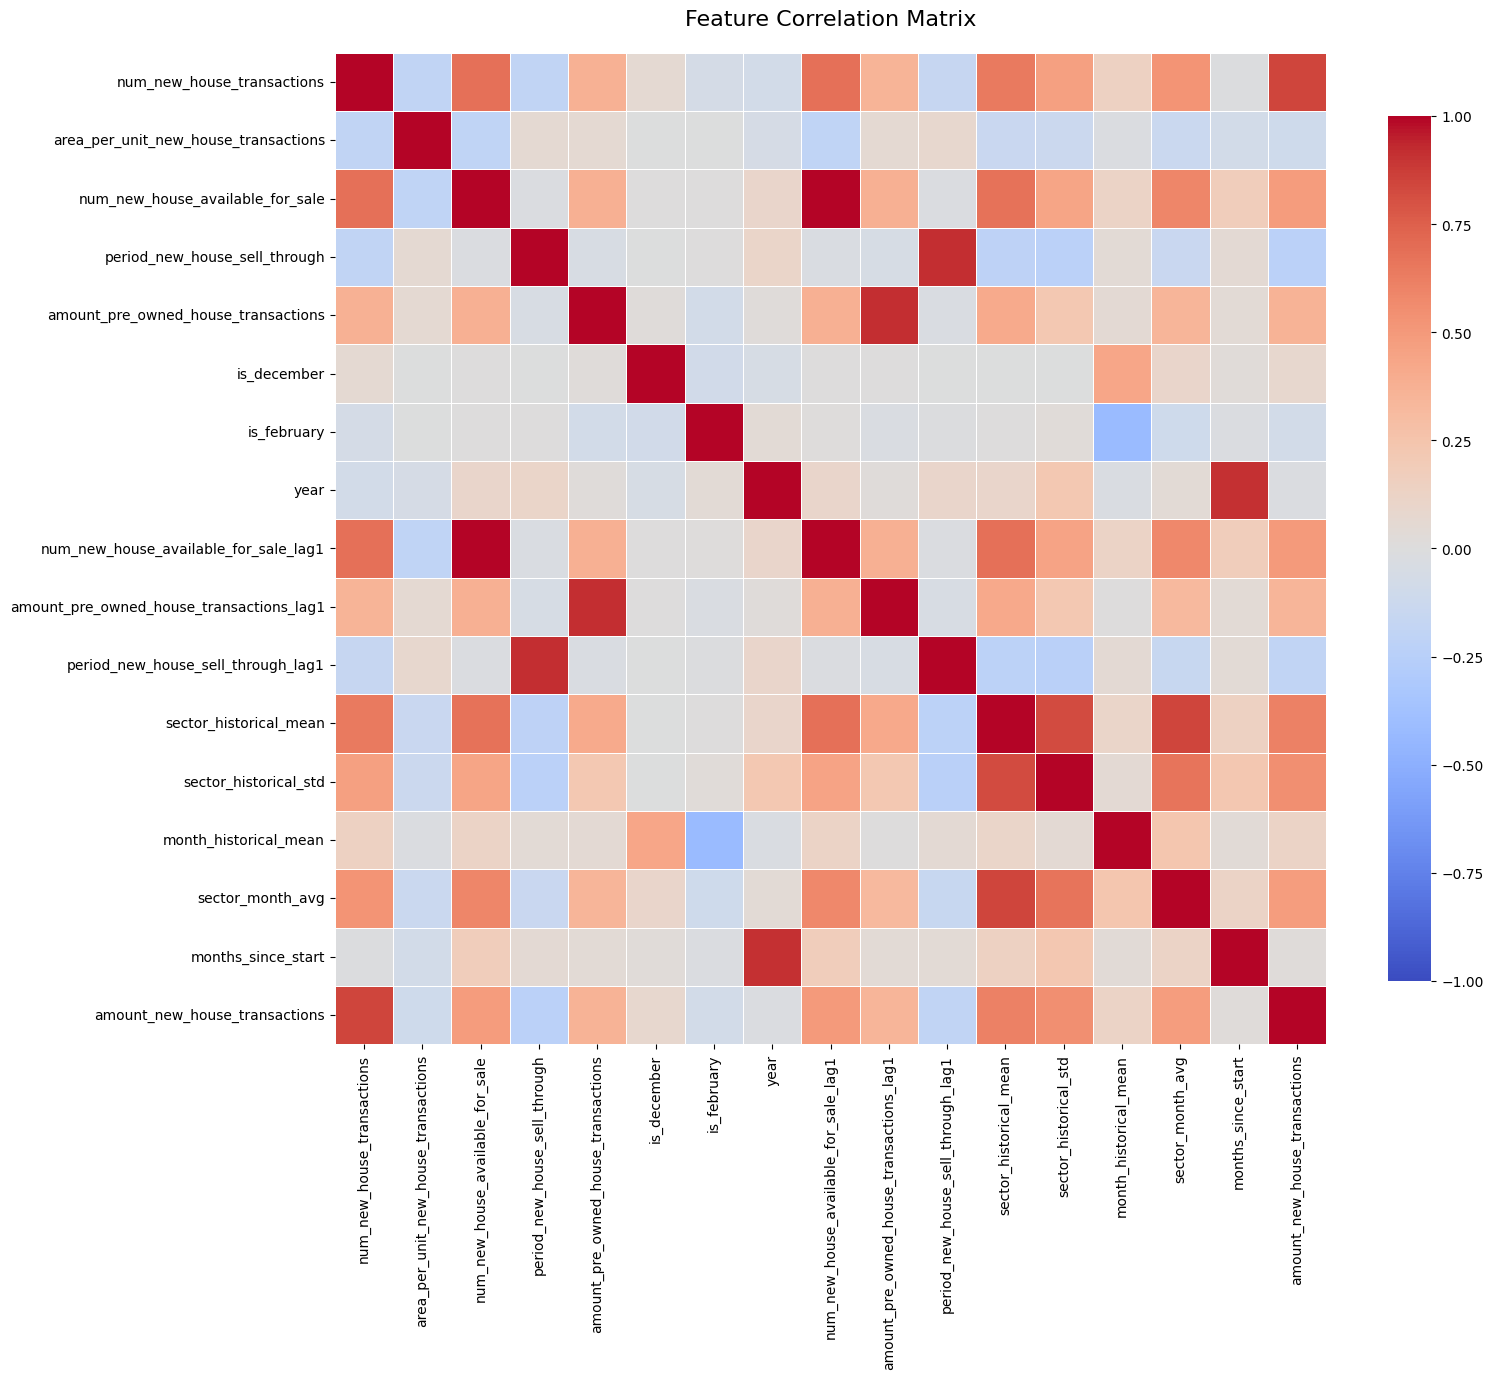


HIGHLY CORRELATED FEATURE PAIRS (|correlation| >= 0.8)
                          Feature 1                                Feature 2  Correlation
   num_new_house_available_for_sale    num_new_house_available_for_sale_lag1     0.992337
amount_pre_owned_house_transactions amount_pre_owned_house_transactions_lag1     0.917930
      period_new_house_sell_through       period_new_house_sell_through_lag1     0.916330
                               year                       months_since_start     0.909290
             sector_historical_mean                         sector_month_avg     0.844737
             sector_historical_mean                    sector_historical_std     0.821831

Total pairs found: 6


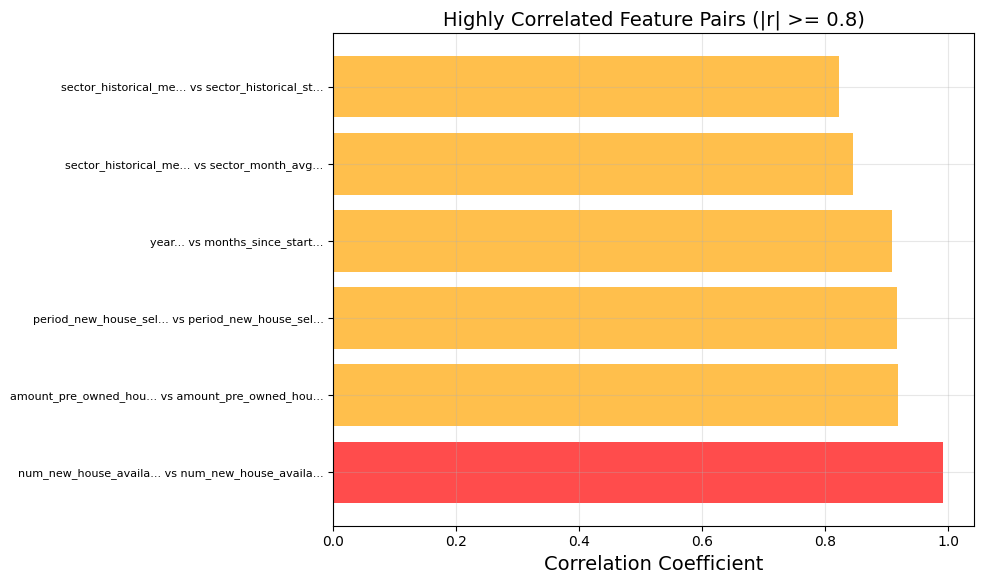

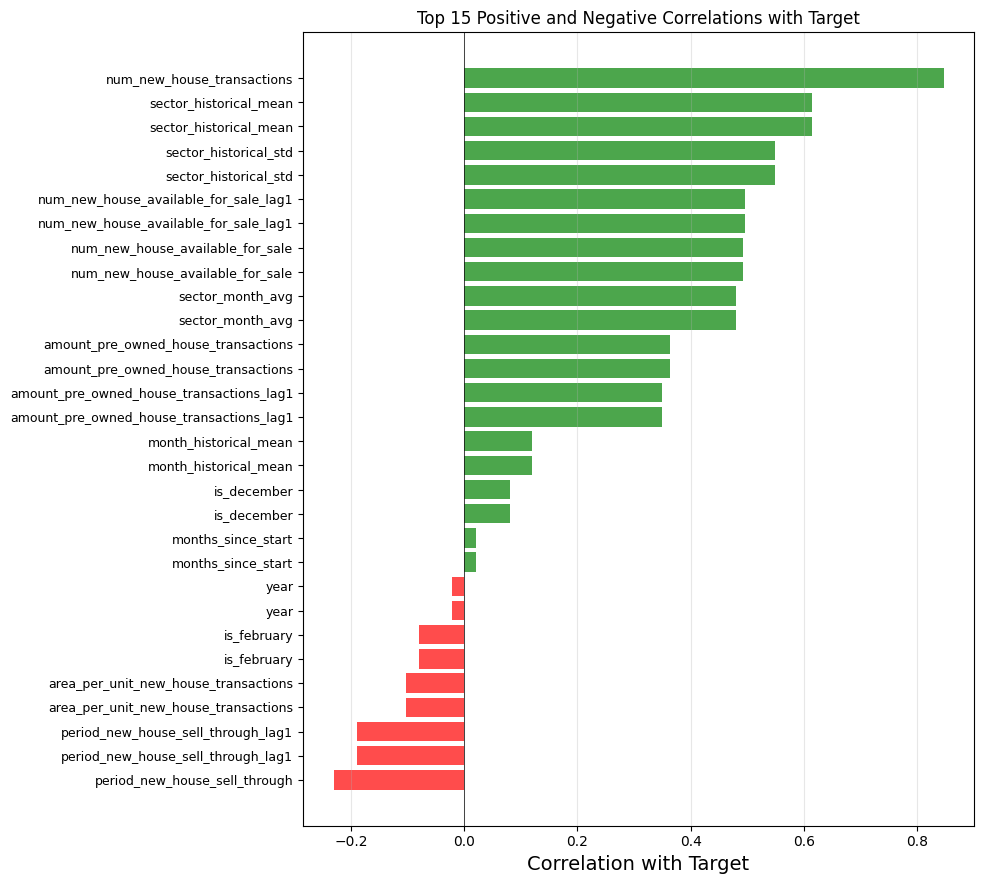


CORRELATION WITH TARGET STATISTICS
Highest positive correlation: 0.8466 (num_new_house_transactions)
Highest negative correlation: -0.2305 (period_new_house_sell_through)
Mean absolute correlation: 0.3149
Features with |correlation| > 0.5: 3
Features with |correlation| > 0.3: 8


In [14]:
# ==========================================
# 3. FEATURE CORRELATION ANALYSIS
# ==========================================

# Calculate correlation matrix for all features
target_col = 'amount_new_house_transactions'
non_features = ['month', 'date', 'sector', target_col]
feature_cols = [col for col in df.columns if col not in non_features]

# Create correlation matrix
correlation_matrix = df[feature_cols + [target_col]].corr()

# ==========================================
# PLOT 1: Full Correlation Heatmap
# ==========================================
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            annot=False,  # Set to True if you want to see values (can be crowded)
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# ==========================================
# PLOT 2: High Correlation Pairs
# ==========================================

# Find highly correlated feature pairs (excluding target)
correlation_threshold = 0.8
feature_corr_matrix = df[feature_cols].corr()

# Get upper triangle to avoid duplicates
upper_triangle = np.triu(np.ones_like(feature_corr_matrix), k=1).astype(bool)
high_corr_pairs = []

for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        corr_value = feature_corr_matrix.iloc[i, j]
        if abs(corr_value) >= correlation_threshold:
            high_corr_pairs.append({
                'Feature 1': feature_corr_matrix.columns[i],
                'Feature 2': feature_corr_matrix.columns[j],
                'Correlation': corr_value
            })

# Display high correlation pairs
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                               key=abs, 
                                                               ascending=False)
    print("\n" + "="*70)
    print(f"HIGHLY CORRELATED FEATURE PAIRS (|correlation| >= {correlation_threshold})")
    print("="*70)
    print(high_corr_df.to_string(index=False))
    print(f"\nTotal pairs found: {len(high_corr_df)}")
    
    # Visualize high correlation pairs
    if len(high_corr_df) > 0:
        fig, ax = plt.subplots(figsize=(10, max(6, len(high_corr_df) * 0.4)))
        colors = ['red' if abs(x) > 0.95 else 'orange' for x in high_corr_df['Correlation']]
        ax.barh(range(len(high_corr_df)), high_corr_df['Correlation'], color=colors, alpha=0.7)
        ax.set_yticks(range(len(high_corr_df)))
        ax.set_yticklabels([f"{row['Feature 1'][:20]}... vs {row['Feature 2'][:20]}..." 
                            for _, row in high_corr_df.iterrows()], fontsize=8)
        ax.set_xlabel('Correlation Coefficient')
        ax.set_title(f'Highly Correlated Feature Pairs (|r| >= {correlation_threshold})')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print(f"\nNo feature pairs with |correlation| >= {correlation_threshold} found.")

# ==========================================
# PLOT 3: Top Correlations with Target
# ==========================================

# Get correlations with target variable
target_correlations = correlation_matrix[target_col].drop(target_col).sort_values(ascending=False)

# Plot top positive and negative correlations
n_top = 15
top_positive = target_correlations.head(n_top)
top_negative = target_correlations.tail(n_top)
top_features = pd.concat([top_positive, top_negative]).sort_values()

fig, ax = plt.subplots(figsize=(10, max(8, len(top_features) * 0.3)))
colors = ['green' if x > 0 else 'red' for x in top_features]
ax.barh(range(len(top_features)), top_features, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features.index, fontsize=9)
ax.set_xlabel('Correlation with Target')
ax.set_title(f'Top {n_top} Positive and Negative Correlations with Target', fontsize=12)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Print correlation statistics
print("\n" + "="*70)
print("CORRELATION WITH TARGET STATISTICS")
print("="*70)
print(f"Highest positive correlation: {target_correlations.max():.4f} ({target_correlations.idxmax()})")
print(f"Highest negative correlation: {target_correlations.min():.4f} ({target_correlations.idxmin()})")
print(f"Mean absolute correlation: {target_correlations.abs().mean():.4f}")
print(f"Features with |correlation| > 0.5: {(target_correlations.abs() > 0.5).sum()}")
print(f"Features with |correlation| > 0.3: {(target_correlations.abs() > 0.3).sum()}")

# 4. PANEL DATA - CROSS VALIDATION

In [15]:
# ==========================================
# 4.1 CROSS-VALIDATION SETUP
# ==========================================

print("="*60)
print("CROSS-VALIDATION SETUP")
print("="*60)

# Sort data by time (critical for time series)
df = df.sort_values(['month', 'sector']).reset_index(drop=True)

# Check data span
print(f"Data span: {df['month'].min()} to {df['month'].max()}")
print(f"Total months: {df['month'].nunique()}")
print(f"Total sectors: {df['sector'].nunique()}")
print(f"Total rows: {len(df)}")

# Define features and target
target_col = 'amount_new_house_transactions'
non_features = ['month', 'date', 'sector', target_col]
feature_cols = [col for col in df.columns if col not in non_features]

print(f"\nFeatures for model: {len(feature_cols)}")

# Prepare X and y
X = df[feature_cols]
y = df[target_col]

# Remove rows where target is NaN
mask = ~y.isna()
X = X[mask]
y = y[mask]
print(f"After removing NaN targets: {len(X)} rows")

# Simple TimeSeriesSplit
# For monthly data: test_size = number of months to use as test
# Let's use 6 months as test set for each fold
tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=6 * df['sector'].nunique(),  # 6 months * number of sectors
    gap=0  # No gap needed for monthly data
)

# Display the splits
print("\nCross-validation splits:")
print("-" * 40)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_months = df.iloc[train_idx]['month'].unique()
    test_months = df.iloc[test_idx]['month'].unique()
    print(f"Fold {i+1}:")
    print(f"  Train: {len(train_idx):,} rows ({len(train_months)} months)")
    print(f"  Test:  {len(test_idx):,} rows ({len(test_months)} months)")
    print(f"  Test period: {test_months.min()} to {test_months.max()}")

CROSS-VALIDATION SETUP
Data span: 2019-01-01 00:00:00 to 2024-07-01 00:00:00
Total months: 67
Total sectors: 95
Total rows: 5433

Features for model: 16
After removing NaN targets: 5433 rows

Cross-validation splits:
----------------------------------------
Fold 1:
  Train: 2,583 rows (33 months)
  Test:  570 rows (8 months)
  Test period: 2021-09-01 00:00:00 to 2022-04-01 00:00:00
Fold 2:
  Train: 3,153 rows (40 months)
  Test:  570 rows (8 months)
  Test period: 2022-04-01 00:00:00 to 2022-11-01 00:00:00
Fold 3:
  Train: 3,723 rows (47 months)
  Test:  570 rows (8 months)
  Test period: 2022-11-01 00:00:00 to 2023-06-01 00:00:00
Fold 4:
  Train: 4,293 rows (54 months)
  Test:  570 rows (8 months)
  Test period: 2023-06-01 00:00:00 to 2024-01-01 00:00:00
Fold 5:
  Train: 4,863 rows (61 months)
  Test:  570 rows (7 months)
  Test period: 2024-01-01 00:00:00 to 2024-07-01 00:00:00


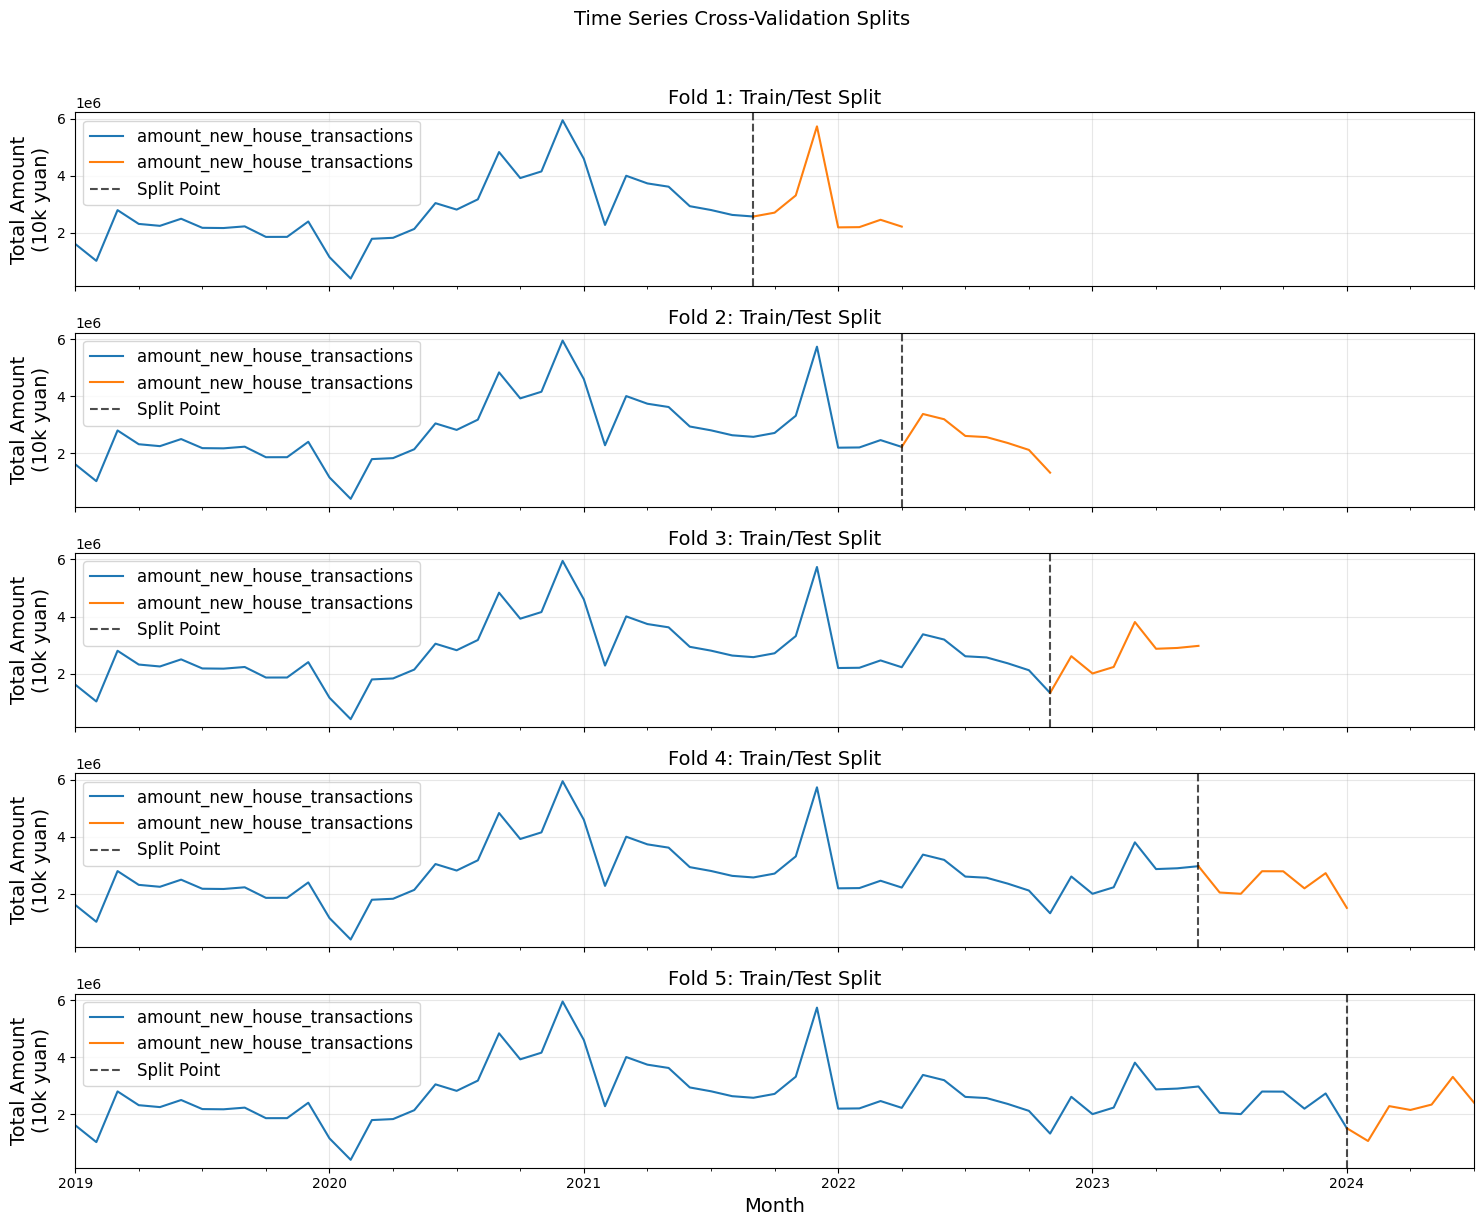


SPLIT STATISTICS

Fold 1:
  Train mean: 33,885
  Test mean:  38,492
  Difference: +13.6%

Fold 2:
  Train mean: 34,718
  Test mean:  31,281
  Difference: -9.9%

Fold 3:
  Train mean: 34,192
  Test mean:  31,237
  Difference: -8.6%

Fold 4:
  Train mean: 33,799
  Test mean:  29,970
  Difference: -11.3%

Fold 5:
  Train mean: 33,350
  Test mean:  26,080
  Difference: -21.8%


In [16]:
# ==========================================
# 4.2 VISUALIZE CROSS-VALIDATION SPLITS
# ==========================================

# Since we have multiple sectors, let's aggregate by month for visualization
monthly_target = df.groupby('month')[target_col].sum().reset_index()
monthly_target = monthly_target.set_index('month').sort_index()

# Create figure
fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Time Series Cross-Validation Splits', fontsize=14, y=1.02)

# Plot each fold
fold = 0
for train_idx, test_idx in tscv.split(X):
    # Get train/test months
    train_months = df.iloc[train_idx]['month'].unique()
    test_months = df.iloc[test_idx]['month'].unique()
    
    # Filter monthly aggregated data
    train_data = monthly_target[monthly_target.index.isin(train_months)]
    test_data = monthly_target[monthly_target.index.isin(test_months)]
    
    # Plot
    train_data.plot(ax=axes[fold], 
                    label='Training Set',
                    color='#1f77b4',
                    title=f'Fold {fold+1}: Train/Test Split')
    test_data.plot(ax=axes[fold], 
                   label='Test Set',
                   color='#ff7f0e')
    
    # Add vertical line at split point
    axes[fold].axvline(test_data.index.min(), 
                       color='black', 
                       ls='--', 
                       alpha=0.7,
                       label='Split Point')
    
    # Format
    axes[fold].set_ylabel('Total Amount\n(10k yuan)')
    axes[fold].legend(loc='upper left')
    axes[fold].grid(True, alpha=0.3)
    
    fold += 1

axes[-1].set_xlabel('Month')
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*40)
print("SPLIT STATISTICS")
print("="*40)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_y = y.iloc[train_idx]
    test_y = y.iloc[test_idx]
    print(f"\nFold {i+1}:")
    print(f"  Train mean: {train_y.mean():,.0f}")
    print(f"  Test mean:  {test_y.mean():,.0f}")
    print(f"  Difference: {(test_y.mean() - train_y.mean())/train_y.mean()*100:+.1f}%")

# 5. MODELING - XGBoost and Visualisations

In [17]:
# ==========================================
# 5.1 XGBOOST MODELING WITH CROSS-VALIDATION
# ==========================================

# Define features and target
target_col = 'amount_new_house_transactions'
non_features = [
    'month', 
    'date', 
    'sector', 
    'target_col',
    'num_new_house_available_for_sale',
    'amount_pre_owned_house_transactions',
    'period_new_house_sell_through'
]

feature_cols = [col for col in df.columns if col not in non_features]

print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")

# Storage for results
fold = 0
preds = []
scores = []
models = []

for train_idx, test_idx in tscv.split(df):
    print(f"\n--- Fold {fold + 1} ---")
    
    # Split data
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    
    # Prepare X and y
    X_train = train[feature_cols]
    y_train = train[target_col]
    X_test = test[feature_cols]
    y_test = test[target_col]
    
    # Handle NaN in target
    train_mask = ~y_train.isna()
    test_mask = ~y_test.isna()
    
    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]
    
    print(f"Train: {len(X_train)} | Test: {len(X_test)}")
    
    # XGBoost model with early_stopping_rounds in constructor
    reg = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mape',
        early_stopping_rounds=50  # Move it here
    )
    
    # Train
    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )
    
    # Predict
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    # Calculate competition score using custom function
    comp_score = custom_competition_score(y_test.values, y_pred)
    scores.append(comp_score)
    models.append(reg)
    
    # Also calculate RMSE for reference
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Diagnostic info
    ape = np.abs((y_pred - y_test.values) / y_test.values)
    extreme_pct = 100 * np.sum(ape > 1.0) / len(ape)
    valid_pct = 100 * np.sum(ape <= 1.0) / len(ape)
    
    print(f"Competition Score: {comp_score:.4f}")
    print(f"RMSE: {rmse:,.0f}")
    print(f"Samples with APE > 100%: {extreme_pct:.1f}%")
    print(f"Samples with APE ≤ 100%: {valid_pct:.1f}%")
    
    fold += 1

# Summary
print("\n" + "="*40)
print(f"Average Competition Score: {np.mean(scores):.4f}")
print(f"Std Competition Score: {np.std(scores):.4f}")
print(f"Best Competition Score: {np.max(scores):.4f}")
print(f"Worst Competition Score: {np.min(scores):.4f}")

Features: 14
Target: amount_new_house_transactions

--- Fold 1 ---
Train: 2583 | Test: 570
[0]	validation_0-mape:11.50757	validation_1-mape:8.19538
[100]	validation_0-mape:4.38054	validation_1-mape:3.14944
[200]	validation_0-mape:1.70231	validation_1-mape:1.26813
[300]	validation_0-mape:0.69186	validation_1-mape:0.55627
[400]	validation_0-mape:0.31345	validation_1-mape:0.28427
[499]	validation_0-mape:0.18006	validation_1-mape:0.18272
Competition Score: 0.9164
RMSE: 14,085
Samples with APE > 100%: 4.9%
Samples with APE ≤ 100%: 95.1%

--- Fold 2 ---
Train: 3153 | Test: 570
[0]	validation_0-mape:11.19001	validation_1-mape:10.51676
[100]	validation_0-mape:4.25600	validation_1-mape:4.02580
[200]	validation_0-mape:1.65358	validation_1-mape:1.59018
[300]	validation_0-mape:0.66960	validation_1-mape:0.66778
[400]	validation_0-mape:0.30665	validation_1-mape:0.32452
[499]	validation_0-mape:0.17364	validation_1-mape:0.19396
Competition Score: 0.9060
RMSE: 7,857
Samples with APE > 100%: 3.7%
Sample

## Visualisation

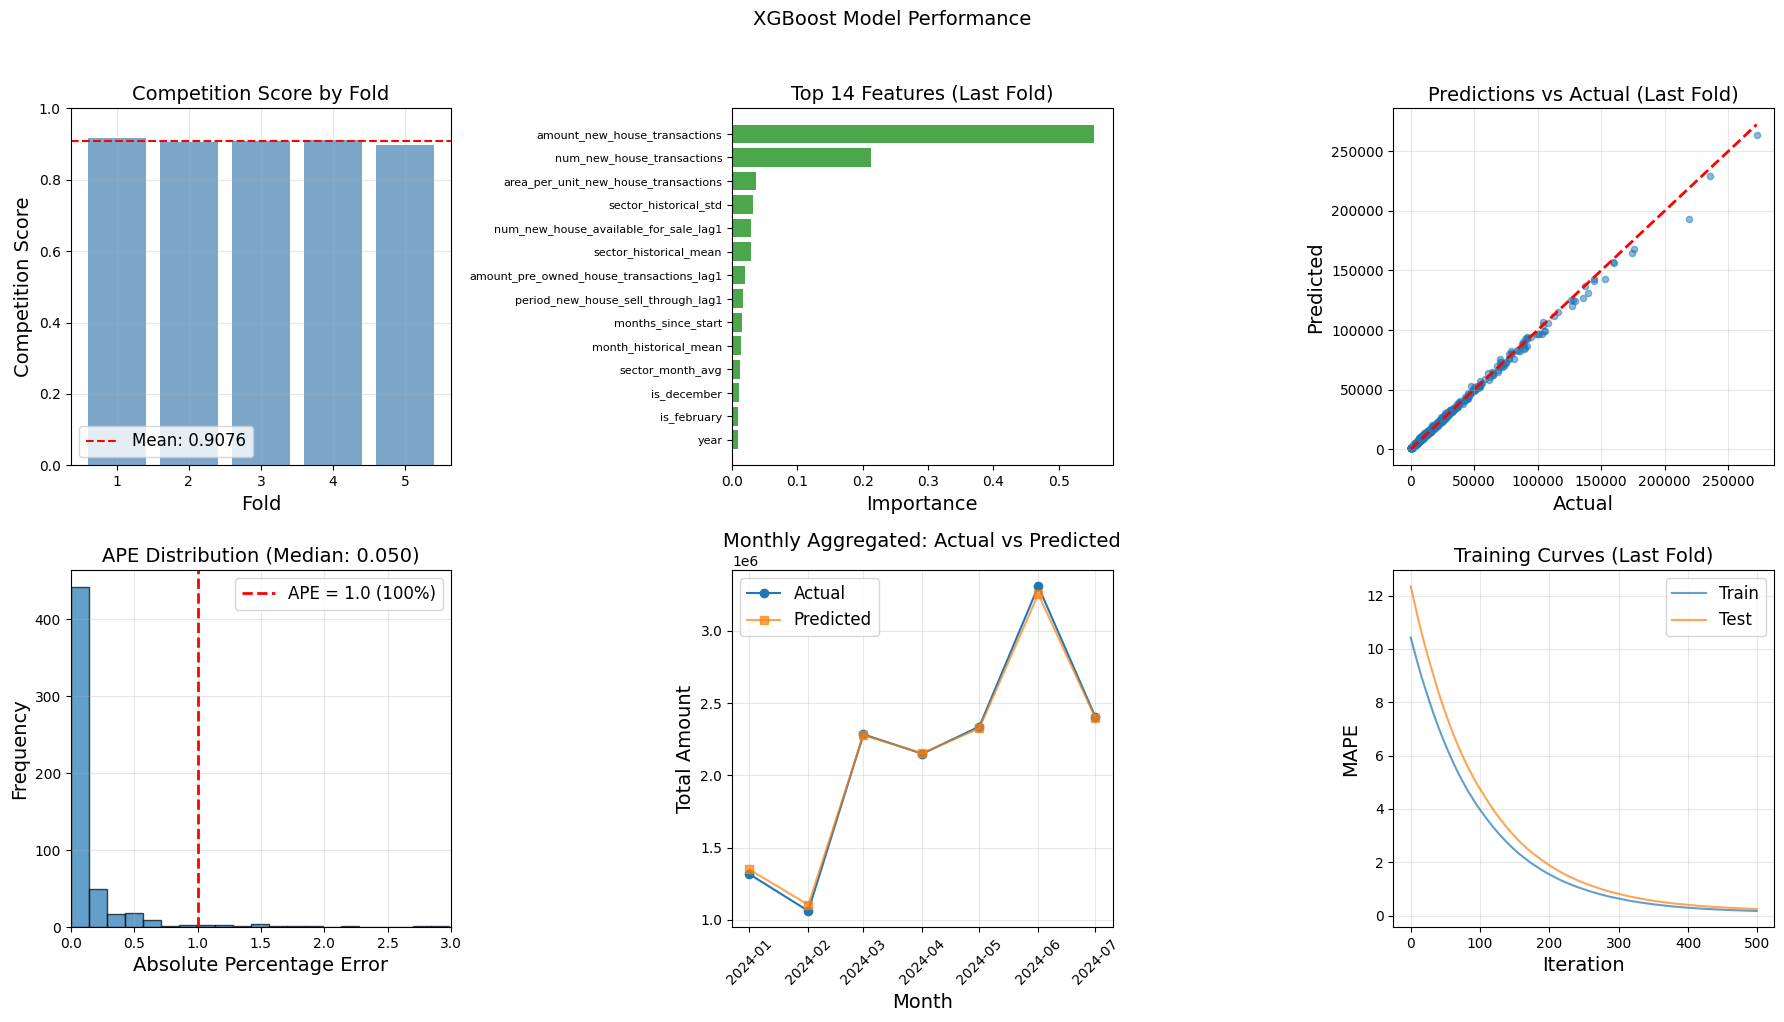


PERFORMANCE SUMMARY
Average Competition Score: 0.9076
Best Fold: 1 (Score: 0.9164)
Worst Fold: 5 (Score: 0.8967
Standard Deviation: 0.0065

Last Fold Diagnostics:
  Samples with APE > 100%: 5.1%
  Samples with APE ≤ 100%: 94.9%
  Median APE: 0.050


In [18]:
# ==========================================
# 5.2 VISUALIZATION OF RESULTS
# ==========================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Competition Score across folds
axes[0, 0].bar(range(1, len(scores)+1), scores, color='steelblue', alpha=0.7)
axes[0, 0].axhline(np.mean(scores), color='red', linestyle='--', label=f'Mean: {np.mean(scores):.4f}')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Competition Score')
axes[0, 0].set_title('Competition Score by Fold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([0, 1])  # Score is between 0 and 1

# 2. Feature importance (from last model)
last_model = models[-1]
importances = last_model.feature_importances_
n_features = min(15, len(importances))  # Use actual number of features or 15, whichever is smaller
indices = np.argsort(importances)[::-1][:n_features]  # Top n_features

axes[0, 1].barh(range(n_features), importances[indices], color='green', alpha=0.7)
axes[0, 1].set_yticks(range(n_features))
axes[0, 1].set_yticklabels([feature_cols[i] for i in indices], fontsize=8)
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title(f'Top {n_features} Features (Last Fold)')
axes[0, 1].invert_yaxis()

# 3. Predictions vs Actual (last fold)
last_test_idx = list(tscv.split(df))[-1][1]
last_test = df.iloc[last_test_idx]
X_last = last_test[feature_cols]
y_last = last_test[target_col]
test_mask = ~y_last.isna()
y_true = y_last[test_mask]
y_pred = preds[-1]

axes[0, 2].scatter(y_true, y_pred, alpha=0.5, s=20)
axes[0, 2].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual')
axes[0, 2].set_ylabel('Predicted')
axes[0, 2].set_title('Predictions vs Actual (Last Fold)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Absolute Percentage Error Distribution (last fold)
ape = np.abs((y_pred - y_true.values) / y_true.values)
axes[1, 0].hist(ape, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(1.0, color='red', linestyle='--', linewidth=2, label='APE = 1.0 (100%)')
axes[1, 0].set_xlabel('Absolute Percentage Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'APE Distribution (Median: {np.median(ape):.3f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, min(3, ape.max())])  # Cap x-axis for better visibility

# 5. Predictions over time (last fold)
test_with_pred = last_test[test_mask].copy()
test_with_pred['predictions'] = y_pred
monthly_actual = test_with_pred.groupby('month')[target_col].sum()
monthly_pred = test_with_pred.groupby('month')['predictions'].sum()

axes[1, 1].plot(monthly_actual.index, monthly_actual.values, label='Actual', marker='o')
axes[1, 1].plot(monthly_pred.index, monthly_pred.values, label='Predicted', marker='s', alpha=0.7)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Total Amount')
axes[1, 1].set_title('Monthly Aggregated: Actual vs Predicted')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Learning curves (last model) - using MAPE
results = last_model.evals_result()
axes[1, 2].plot(results['validation_0']['mape'], label='Train', alpha=0.7)
axes[1, 2].plot(results['validation_1']['mape'], label='Test', alpha=0.7)
axes[1, 2].set_xlabel('Iteration')
axes[1, 2].set_ylabel('MAPE')
axes[1, 2].set_title('Training Curves (Last Fold)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('XGBoost Model Performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print performance summary
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(f"Average Competition Score: {np.mean(scores):.4f}")
print(f"Best Fold: {np.argmax(scores) + 1} (Score: {np.max(scores):.4f})")  # Higher is better
print(f"Worst Fold: {np.argmin(scores) + 1} (Score: {np.min(scores):.4f}")  # Lower is worse
print(f"Standard Deviation: {np.std(scores):.4f}")
print(f"\nLast Fold Diagnostics:")
print(f"  Samples with APE > 100%: {100 * np.sum(ape > 1.0) / len(ape):.1f}%")
print(f"  Samples with APE ≤ 100%: {100 * np.sum(ape <= 1.0) / len(ape):.1f}%")
print(f"  Median APE: {np.median(ape):.3f}")

## Optuna - tuning

In [19]:
# # ------------------------------------------
# # 5.2 XGBoost Hyperparameter Tuning (Option B)
# # ------------------------------------------

# # Features and target
# target_col = 'amount_new_house_transactions'
# non_features = ['month', 'date', 'sector', target_col]
# feature_cols = [col for col in df.columns if col not in non_features]

# X = df[feature_cols]
# y = df[target_col]

# # Remove NaNs in target
# mask = ~y.isna()
# X = X[mask]
# y = y[mask]

# # TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=3)

# # Define Optuna objective for regression
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#         "gamma": trial.suggest_float("gamma", 0, 5),
#         "random_state": 42
#     }
    
#     fold_scores = []
    
#     for train_idx, test_idx in tscv.split(X):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
#         model = xgb.XGBRegressor(**params)
#         model.fit(X_train, y_train, verbose=False)  # <- removed early_stopping_rounds
        
#         y_pred = model.predict(X_test)
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         fold_scores.append(rmse)
    
#     return np.mean(fold_scores)

# # Create Optuna study
# study = optuna.create_study(direction="minimize", study_name="xgb_regression_study")
# study.optimize(objective, n_trials=20, show_progress_bar=True, n_jobs=-1)

# # Best hyperparameters
# best_params = study.best_params
# print("\nBest hyperparameters found by Optuna:")
# print(best_params)

In [20]:
# study.best_params

# 6. PREDICTING THE FUTURE
Retraining on all data

To Predict the future we need an emtpy dataframe for future date ranges.

Run those dates through our feature creation code + lag creation

In [21]:
# ==========================================
# 6. PREDICTIONS FOR SUBMISSION
# ==========================================

# ------------------------------------------
# 6.1 Load and Decode Submission Template
# ------------------------------------------

submission_template = pd.read_csv("/Users/nikola/Python/KaggleCompetition/data/sample_submission.csv")
print(f"Submission shape: {submission_template.shape}")

# Parse the ID format
submission_template['year'] = submission_template['id'].str.split(' ').str[0].astype(int)
submission_template['month_abbr'] = submission_template['id'].str.split('_').str[0].str.split(' ').str[1]
submission_template['sector'] = submission_template['id'].str.split('_').str[1]
submission_template['month'] = pd.to_datetime(
    submission_template['year'].astype(str) + ' ' + submission_template['month_abbr'],
    format='%Y %b'
)

# ------------------------------------------
# 6.2 Prepare Original Features for Future Months
# ------------------------------------------

# Create a dataframe with all sector-month combinations
future_base = submission_template[['month', 'sector']].copy()

# Get the last known values for each sector for the original features
last_values = df.groupby('sector')[['num_new_house_available_for_sale',
                                     'amount_pre_owned_house_transactions', 
                                     'period_new_house_sell_through']].last()

# Merge these values with future months (assume they stay constant)
future_base = future_base.merge(last_values, left_on='sector', right_index=True, how='left')

# For the new sector 95, fill with overall median
for col in ['num_new_house_available_for_sale', 'amount_pre_owned_house_transactions', 'period_new_house_sell_through']:
    future_base.loc[:, col] = future_base[col].fillna(df[col].median())

# ------------------------------------------
# 6.3 Create Combined Dataset
# ------------------------------------------

# Combine historical data with future data
combined = pd.concat([
    df,
    future_base
], ignore_index=True)

combined = combined.sort_values(['sector', 'month']).reset_index(drop=True)

print(f"Combined shape: {combined.shape}")

# ------------------------------------------
# 6.4 Regenerate ALL Features on Combined Dataset
# ------------------------------------------

# Time features
combined['is_december'] = (combined['month'].dt.month == 12).astype(int)
combined['is_february'] = (combined['month'].dt.month == 2).astype(int)
combined['year'] = combined['month'].dt.year

# Lag features (will use historical values for future months)
for feature in ['num_new_house_available_for_sale', 'amount_pre_owned_house_transactions', 'period_new_house_sell_through']:
    combined[f'{feature}_lag1'] = combined.groupby('sector')[feature].shift(1)

# Time series features
combined['sector_historical_mean'] = combined.groupby('sector')[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)
combined['sector_historical_std'] = combined.groupby('sector')[target_col].transform(
    lambda x: x.expanding().std().shift(1)
)
combined['month_historical_mean'] = combined.groupby(combined['month'].dt.month)[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)
combined['sector_month_avg'] = combined.groupby(['sector', combined['month'].dt.month])[target_col].transform(
    lambda x: x.expanding().mean().shift(1)
)
combined['months_since_start'] = combined.groupby('sector').cumcount()

# Define features (same as training)
target_col = 'amount_new_house_transactions'
non_features = [
    'month', 'date', 'sector', target_col,
    'num_new_house_available_for_sale',
    'amount_pre_owned_house_transactions',
    'period_new_house_sell_through'
]
feature_cols = [col for col in combined.columns if col not in non_features]

print(f"\nInitial feature count: {len(feature_cols)}")

# ------------------------------------------
# 6.5 Get Submission Data and Filter Features
# ------------------------------------------

# Get submission rows FIRST
submission_mask = combined['month'].isin(submission_template['month'])
X_submission_temp = combined[submission_mask][feature_cols]

# NOW filter features based on missing data
features_with_data = []
for col in feature_cols:
    missing_pct = X_submission_temp[col].isna().sum() / len(X_submission_temp)
    if missing_pct < 0.9:  # Keep features with <90% missing
        features_with_data.append(col)
    else:
        print(f"Removing {col}: {missing_pct*100:.1f}% missing")

feature_cols = features_with_data
print(f"\nUsing {len(feature_cols)} features after filtering")

# ------------------------------------------
# 6.6 Train Final Model
# ------------------------------------------

train_mask = combined[target_col].notna()
X_train = combined[train_mask][feature_cols].dropna()
y_train = combined[train_mask][target_col].loc[X_train.index]

print(f"\nTraining on {len(X_train)} samples")

final_model = xgb.XGBRegressor(
    n_estimators=974,
    max_depth=4,
    learning_rate=0.03397760168814681,
    subsample=0.8701413713402404,
    colsample_bytree=0.8128659290802385,
    min_child_weight=9,
    gamma=1.13656860535782,
    random_state=42,
    eval_metric='mape'
)

final_model.fit(X_train, y_train)

# ------------------------------------------
# 6.7 Make Predictions
# ------------------------------------------

# Get submission rows with filtered features
X_submission = combined[submission_mask][feature_cols].copy()

print(f"\nSubmission features - Missing values:")
print(X_submission.isna().sum())

# Fill any remaining NaN with training medians
for col in feature_cols:
    if X_submission[col].isna().any():
        X_submission.loc[:, col] = X_submission[col].fillna(X_train[col].median())

predictions = final_model.predict(X_submission)

# Clip negative predictions to 0
predictions = np.maximum(predictions, 0)

print(f"\nPredictions:")
print(f"  Min: {predictions.min():,.0f}")
print(f"  Max: {predictions.max():,.0f}")
print(f"  Mean: {predictions.mean():,.0f}")
print(f"  Non-zero: {(predictions > 0).sum()}/{len(predictions)}")

# Create submission
submission_template['amount'] = predictions
submission_template[['id', 'amount']].to_csv("/Users/nikola/Python/KaggleCompetition/output/XGBOOST/submission.csv", index=False)
print("\n✓ Submission file saved!")

Submission shape: (1152, 2)
Combined shape: (6585, 19)

Initial feature count: 13
Removing num_new_house_transactions: 100.0% missing
Removing area_per_unit_new_house_transactions: 100.0% missing

Using 11 features after filtering

Training on 3826 samples

Submission features - Missing values:
is_december                                  0
is_february                                  0
year                                         0
num_new_house_available_for_sale_lag1        3
amount_pre_owned_house_transactions_lag1    16
period_new_house_sell_through_lag1           3
sector_historical_mean                      12
sector_historical_std                       24
month_historical_mean                        0
sector_month_avg                            37
months_since_start                           0
dtype: int64

Predictions:
  Min: 0
  Max: 144,695
  Mean: 28,406
  Non-zero: 1048/1152

✓ Submission file saved!


# 7. SAVE TO THE SAMPLE SUBMISSION

VISUALIZING PREDICTIONS


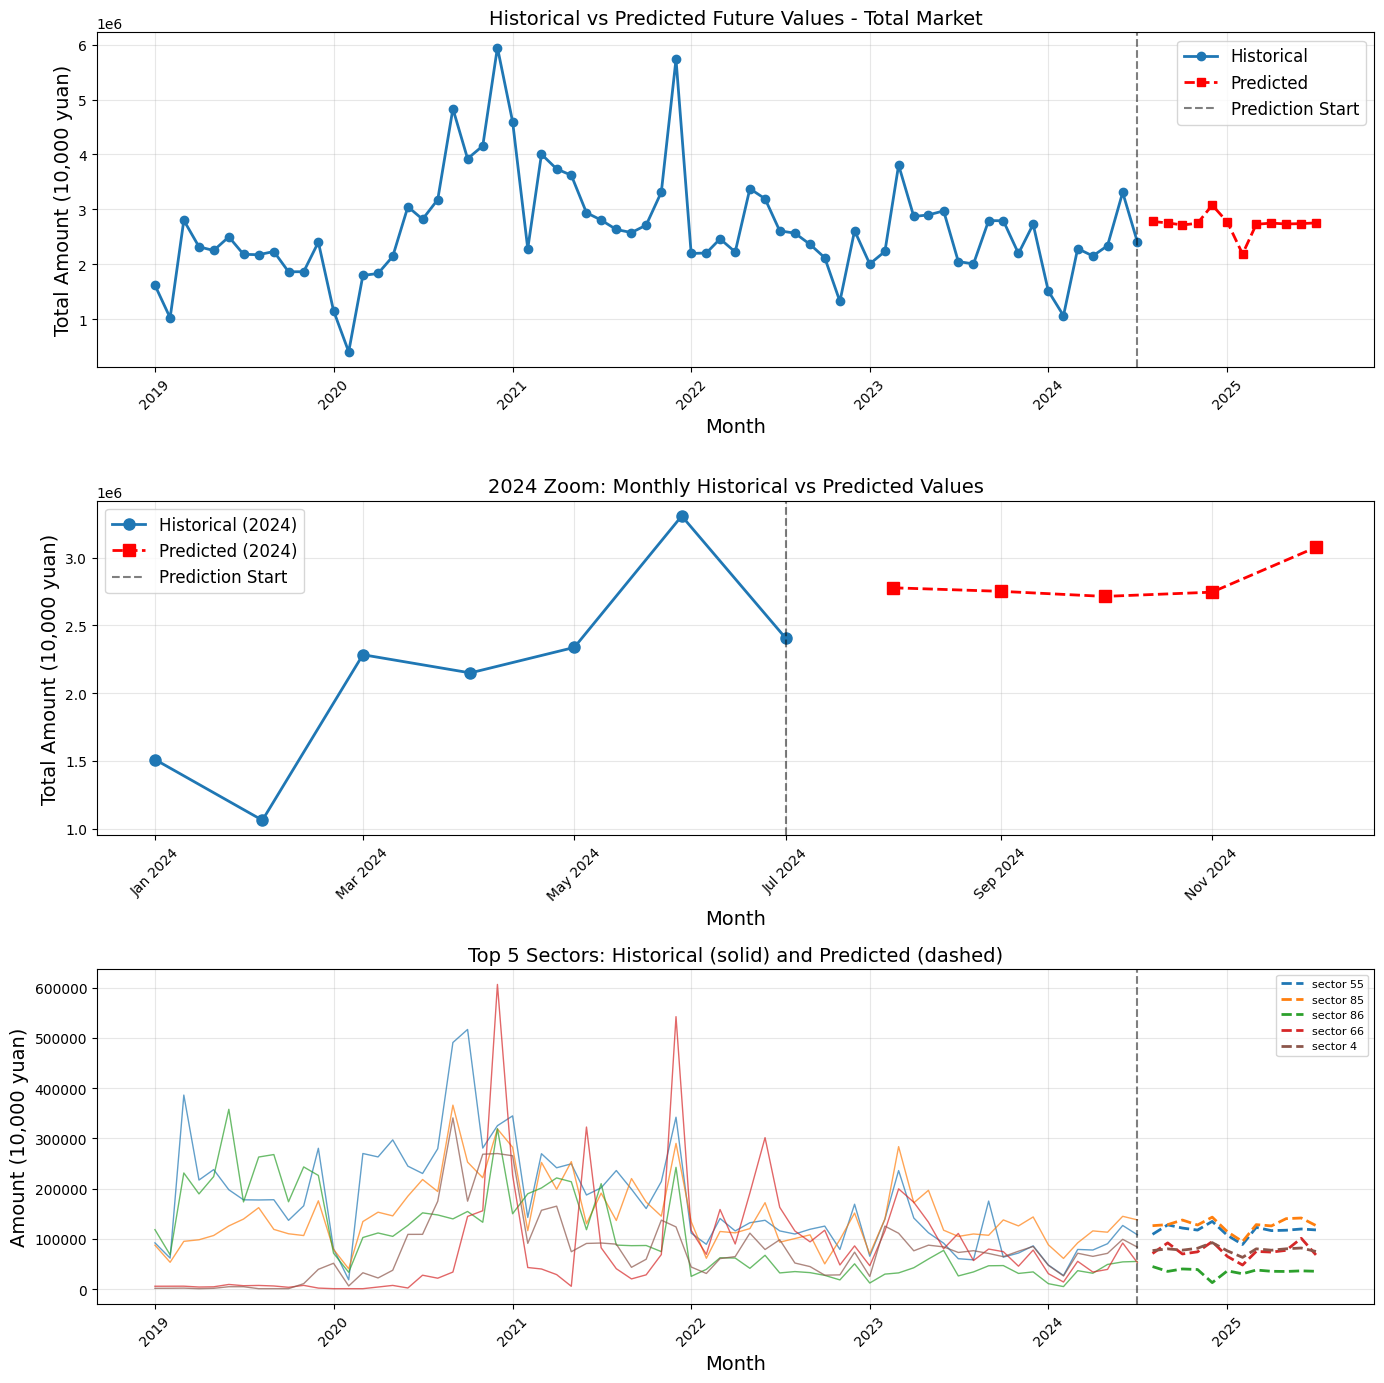


PREDICTION SUMMARY

Historical last 3 months avg: 2,684,372
Predicted next 3 months avg: 2,748,592
Expected growth rate: +2.4%

2024 Specific:
  Historical 2024 avg: 2,151,327
  Predicted 2024 avg: 2,813,851
  2024 growth: +30.8%

Top 3 sectors predicted growth:
  sector 55: +38.4%
  sector 85: +11.4%
  sector 86: -3.7%

PREDICTION QUALITY CHECKS

Historical data:
  Mean: 32,588
  Median: 16,040
  Std: 49,048

Predictions:
  Mean: 28,406
  Median: 20,996
  Std: 28,636

Mean prediction/historical ratio: 0.87
✓ Predictions are in reasonable range relative to historical data


In [22]:
# ==========================================
# 7.1 VISUALIZE PREDICTIONS
# ==========================================

import matplotlib.pyplot as plt
import numpy as np

print("="*60)
print("VISUALIZING PREDICTIONS")
print("="*60)

# Create future data dataframe with predictions
future_data = combined[combined['month'].isin(submission_template['month'])].copy()
future_data['predicted_amount'] = predictions

# Get historical data
last_historical_month = df['month'].max()
historical_data = df.copy()

fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# ------------------------------------------
# Plot 1: Total monthly amounts
# ------------------------------------------

# Historical totals
historical_monthly = historical_data.groupby('month')[target_col].sum()

# Future predictions totals
future_monthly = future_data.groupby('month')['predicted_amount'].sum()

# Plot
axes[0].plot(historical_monthly.index, historical_monthly.values, 
             label='Historical', marker='o', linewidth=2, color='#1f77b4')
axes[0].plot(future_monthly.index, future_monthly.values, 
             label='Predicted', marker='s', linewidth=2, linestyle='--', color='red')
axes[0].axvline(last_historical_month, color='black', linestyle='--', alpha=0.5, label='Prediction Start')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Amount (10,000 yuan)')
axes[0].set_title('Historical vs Predicted Future Values - Total Market')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# ------------------------------------------
# Plot 2: Zoom into 2024 Monthly Data
# ------------------------------------------

# Filter for 2024 data
hist_2024 = historical_monthly[historical_monthly.index.year == 2024]
future_2024 = future_monthly[future_monthly.index.year == 2024]

# Combine for complete 2024 view
axes[1].plot(hist_2024.index, hist_2024.values, 
             label='Historical (2024)', marker='o', linewidth=2, markersize=8, color='#1f77b4')
axes[1].plot(future_2024.index, future_2024.values, 
             label='Predicted (2024)', marker='s', linewidth=2, markersize=8, linestyle='--', color='red')
axes[1].axvline(last_historical_month, color='black', linestyle='--', alpha=0.5, label='Prediction Start')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Amount (10,000 yuan)')
axes[1].set_title('2024 Zoom: Monthly Historical vs Predicted Values')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Add month labels for clarity
axes[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))

# ------------------------------------------
# Plot 3: Top 5 sectors
# ------------------------------------------

# Find top 5 sectors by historical volume
top_sectors = historical_data.groupby('sector')[target_col].sum().nlargest(5).index

colors = plt.cm.tab10(np.linspace(0, 0.5, 5))

for i, sector in enumerate(top_sectors):
    # Historical data for this sector
    sector_hist = historical_data[historical_data['sector'] == sector].groupby('month')[target_col].sum()
    
    # Future predictions for this sector
    sector_future = future_data[future_data['sector'] == sector].groupby('month')['predicted_amount'].sum()
    
    # Plot historical as solid line
    axes[2].plot(sector_hist.index, sector_hist.values, 
                 alpha=0.7, linewidth=1, color=colors[i])
    
    # Plot predictions as dashed line
    if len(sector_future) > 0:
        axes[2].plot(sector_future.index, sector_future.values, 
                     linestyle='--', linewidth=2, color=colors[i], 
                     label=f'{sector[:30]}...' if len(sector) > 30 else sector)

# Add vertical line at prediction start
axes[2].axvline(last_historical_month, color='black', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Amount (10,000 yuan)')
axes[2].set_title('Top 5 Sectors: Historical (solid) and Predicted (dashed)')
axes[2].legend(fontsize=8, loc='best')
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ------------------------------------------
# Summary Statistics
# ------------------------------------------

print("\n" + "="*40)
print("PREDICTION SUMMARY")
print("="*40)

# Monthly growth
hist_last_3_months = historical_monthly.tail(3).mean()
pred_first_3_months = future_monthly.head(3).mean()
growth_rate = (pred_first_3_months - hist_last_3_months) / hist_last_3_months * 100

print(f"\nHistorical last 3 months avg: {hist_last_3_months:,.0f}")
print(f"Predicted next 3 months avg: {pred_first_3_months:,.0f}")
print(f"Expected growth rate: {growth_rate:+.1f}%")

# 2024 specific statistics
print("\n2024 Specific:")
print(f"  Historical 2024 avg: {hist_2024.mean():,.0f}")
print(f"  Predicted 2024 avg: {future_2024.mean():,.0f}")
print(f"  2024 growth: {((future_2024.mean() - hist_2024.mean()) / hist_2024.mean() * 100):+.1f}%")

# Sector predictions
print("\nTop 3 sectors predicted growth:")
for sector in top_sectors[:3]:
    sector_hist_data = historical_data[historical_data['sector'] == sector][target_col]
    hist_avg = sector_hist_data.tail(12).mean() if len(sector_hist_data) >= 12 else sector_hist_data.mean()
    
    sector_pred_data = future_data[future_data['sector'] == sector]['predicted_amount']
    pred_avg = sector_pred_data.mean() if len(sector_pred_data) > 0 else 0
    
    growth = (pred_avg - hist_avg) / hist_avg * 100 if hist_avg > 0 else 0
    print(f"  {sector[:40]}: {growth:+.1f}%")

# Check prediction reasonableness
print("\n" + "="*40)
print("PREDICTION QUALITY CHECKS")
print("="*40)

# Compare distributions
print(f"\nHistorical data:")
print(f"  Mean: {historical_data[target_col].mean():,.0f}")
print(f"  Median: {historical_data[target_col].median():,.0f}")
print(f"  Std: {historical_data[target_col].std():,.0f}")

print(f"\nPredictions:")
print(f"  Mean: {predictions.mean():,.0f}")
print(f"  Median: {np.median(predictions):,.0f}")
print(f"  Std: {predictions.std():,.0f}")

# Distribution similarity ratio
mean_ratio = predictions.mean() / historical_data[target_col].mean()
print(f"\nMean prediction/historical ratio: {mean_ratio:.2f}")
if 0.7 <= mean_ratio <= 1.3:
    print("✓ Predictions are in reasonable range relative to historical data")
else:
    print("⚠️  Predictions may be significantly different from historical patterns")

In [23]:
# Add this after making predictions in section 6.7

print("\n" + "="*60)
print("ZERO PREDICTION ANALYSIS")
print("="*60)

# Find zero predictions
zero_mask = predictions == 0
num_zeros = zero_mask.sum()

print(f"\nTotal zero predictions: {num_zeros}/{len(predictions)} ({100*num_zeros/len(predictions):.1f}%)")

if num_zeros > 0:
    # Get sectors with zero predictions
    zero_data = submission_template[zero_mask].copy()
    zero_data['prediction'] = predictions[zero_mask]
    
    print("\nSectors with zero predictions:")
    sector_zeros = zero_data['sector'].value_counts()
    print(sector_zeros)
    
    print("\nMonths with zero predictions:")
    month_zeros = zero_data['month'].value_counts()
    print(month_zeros)
    
    # Check if these sectors exist in historical data
    print("\nChecking historical data for these sectors:")
    for sector in sector_zeros.index:
        hist_data = df[df['sector'] == sector]
        if len(hist_data) == 0:
            print(f"  {sector}: NOT IN HISTORICAL DATA")
        else:
            print(f"  {sector}: {len(hist_data)} historical records")
            print(f"    Historical mean: {hist_data[target_col].mean():,.0f}")
            print(f"    Historical median: {hist_data[target_col].median():,.0f}")
    
    # Show the actual submission rows with zeros
    print("\nFirst 10 zero predictions:")
    print(zero_data[['id', 'sector', 'month', 'prediction']].head(10))
    
    # Check what features these rows have
    zero_indices = np.where(zero_mask)[0]
    X_submission_zeros = X_submission.iloc[zero_indices]
    
    print("\nFeature values for zero predictions (first 5 rows):")
    print(X_submission_zeros.head())
    
    print("\nFeature statistics for zero predictions:")
    print(X_submission_zeros.describe())

else:
    print("\n✓ No zero predictions found!")


ZERO PREDICTION ANALYSIS

Total zero predictions: 104/1152 (9.0%)

Sectors with zero predictions:
sector
sector 11    4
sector 2     4
sector 3     4
sector 6     4
sector 7     4
sector 9     4
sector 10    4
sector 12    4
sector 72    3
sector 67    3
sector 71    3
sector 43    3
sector 42    3
sector 41    3
sector 47    3
sector 63    3
sector 8     3
sector 5     3
sector 4     3
sector 1     3
sector 68    2
sector 66    2
sector 91    2
sector 69    2
sector 70    2
sector 64    2
sector 39    2
sector 62    2
sector 61    2
sector 46    2
sector 45    2
sector 44    2
sector 40    2
sector 31    2
sector 55    1
sector 53    1
sector 52    1
sector 17    1
sector 37    1
sector 38    1
sector 48    1
sector 89    1
Name: count, dtype: int64

Months with zero predictions:
month
2025-04-01    25
2024-12-01    24
2025-02-01    13
2025-06-01    13
2024-09-01    12
2025-05-01    12
2025-01-01     2
2024-08-01     1
2024-10-01     1
2025-07-01     1
Name: count, dtype: int64

Chec